In [82]:
import FunctionLib
import os
import gc
from tqdm import tqdm
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# %matplotlib widget
basePath = "./sims.TNG/TNG50-1/output"

Snapshot_Init = 71
Snapshot_End = 99
Lbsg_Indices_Array = np.array(
    [117251, 300903, 324123, 329508, 382215,
        400973, 419618, 457431, 460722, 490814]
)

h = 0.6774  # km/Mpc

m_dm = 4.5e-5  # E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27e-8  # E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  # E10M_Sum/(kpc/h)^3


---
### Vmax

In [2]:
Subhalo_Fields = ['SubhaloMassType', 'SubhaloVmax']
PartType4_Fields = ['Masses', 'GFM_Metallicity', 'GFM_StellarFormationTime']


In [3]:
# Load the Vmax data for Lbsg Samples
Lbsg_Vmax_List = list()
for Subhalo_Index in Lbsg_Indices_Array:

    Current_Snapshot = 99

    Subhalo_Dict = il.groupcat.loadSingle(
        basePath, Current_Snapshot, -1, Subhalo_Index)

    Lbsg_Vmax_List.append(Subhalo_Dict['SubhaloVmax'])


In [6]:
# Load the galaxies with stellar mass greater than 1E9 MassOfSun
Subhalos_Dict = il.groupcat.loadSubhalos(basePath, 99, fields=Subhalo_Fields)
condition = (Subhalos_Dict['SubhaloMassType'][:, 4] > 0.1) & (
    Subhalos_Dict['SubhaloMassType'][:, 4] < 100)
Galaxies_Indices = np.where(condition)[0]
Galaxies_Indices.shape


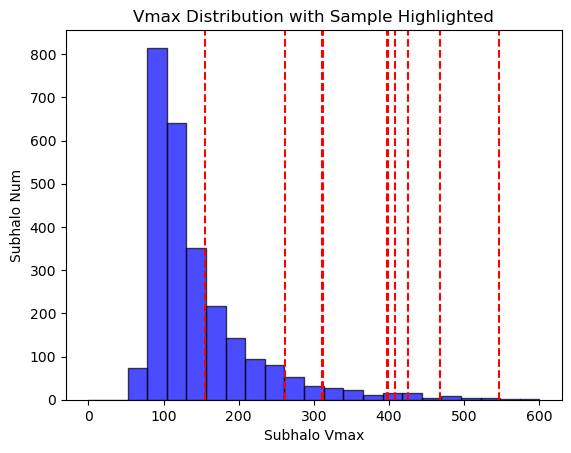

In [11]:
bins = np.linspace(0, 600, 24)
plt.hist(Subhalos_Dict['SubhaloVmax'][Galaxies_Indices],
         bins, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Subhalo Vmax')
plt.ylabel('Subhalo Num')
plt.title('Vmax Distribution with Sample Highlighted')
highlight_values = np.array(Lbsg_Vmax_List)
for value in highlight_values:
    plt.axvline(x=value, color='red', linestyle='dashed',
                linewidth=1.5, label=f'Value: {value}')


This figure shows that the galxies with a huge HI clump tend to have higher circular velocity than others.

---
### Stars Ages

In [12]:
Mass_Averaged_SFT = list()
for Subhalo_Id in tqdm(Galaxies_Indices):
    Subhalo_Dict = il.snapshot.loadSubhalo(
        basePath, Current_Snapshot, Subhalo_Id, partType=4, fields=PartType4_Fields)
    if (len(Subhalo_Dict)) == 1:
        continue
    Stars_Indices = np.where(Subhalo_Dict['GFM_StellarFormationTime'] > 0)[0]
    Mass_Averaged_SFT.append((Subhalo_Dict['Masses'][Stars_Indices]*Subhalo_Dict['GFM_StellarFormationTime']
                             [Stars_Indices]).sum()/Subhalo_Dict['Masses'][Stars_Indices].sum())


100%|██████████| 2620/2620 [11:49<00:00,  3.69it/s] 


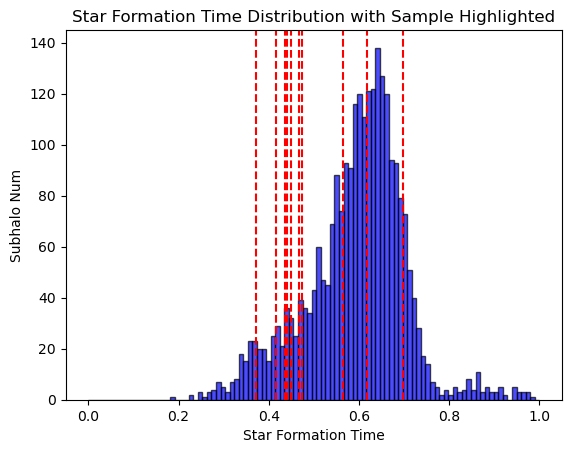

In [30]:
bins = np.linspace(0, 1, 100)
plt.hist(Mass_Averaged_SFT, bins, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Star Formation Time')
plt.ylabel('Subhalo Num')
plt.title('Star Formation Time Distribution with Sample Highlighted')
for id in Lbsg_Indices_Array:
    plt.axvline(x=Mass_Averaged_SFT[np.where(Galaxies_Indices == id)[0][0]], color='red', linestyle='dashed',
                linewidth=1.5, label=f'Value: {Mass_Averaged_SFT[np.where(Galaxies_Indices==id)[0][0]]}')


---
### Gas Cooling

In [84]:
def Cold_Gas_Mass(snap_num, subhalo_id):
    parttype0_fields = ['ElectronAbundance', 'InternalEnergy', 'Masses']
    subhalo_dict = il.snapshot.loadSubhalo(
        basePath, snap_num, subhalo_id, 0, fields=parttype0_fields)
    if len(subhalo_dict) == 1:
        return 0

    x_e = subhalo_dict['ElectronAbundance'].astype(np.float64)
    internal_energy = subhalo_dict['InternalEnergy'].astype(np.float64)
    gas_cell_masses = subhalo_dict['Masses'].astype(np.float64)

    m_p = 1.673E-24
    X_H = 0.76
    unit_switching = 1E10
    mean_molecular_weight = 4*m_p/(1+3*X_H+4*X_H*x_e)
    k_B = 1.38E-16
    gas_cell_temperature_in_Kelvin = 2/3*internal_energy / \
        k_B*unit_switching*mean_molecular_weight
    cold_gas_mass = 0

    for temperature, gas_cell_mass in FunctionLib.Binary_DataIter(gas_cell_temperature_in_Kelvin, gas_cell_masses):
        if temperature < 15000:
            cold_gas_mass += gas_cell_mass
    return cold_gas_mass

Sublink_Tree_Fields=['SubfindID','SnapNum']


In [ ]:
Cold_Gas_Ratio_Matrix=np.zeros(shape=(Lbsg_Indices_Array.shape[0],Snapshot_End-Snapshot_Init))
for lbsg_index in Lbsg_Indices_Array:
    print(lbsg_index)
    merger_tree=il.sublink.loadTree(basePath,Snapshot_End,lbsg_index,Sublink_Tree_Fields,onlyMPB=True)
    for current_snapshot,subfind_index in tqdm(FunctionLib.Binary_DataIter(merger_tree['SnapNum'],merger_tree['SubfindID'])):
        if current_snapshot < Snapshot_Init: break
        cgm=Cold_Gas_Mass(current_snapshot,subfind_index)
        gm=il.groupcat.loadSingle(basePath,current_snapshot,-1,subfind_index)['SubhaloMassType'][0]

        Cold_Gas_Ratio_Matrix[np.where(Lbsg_Indices_Array==lbsg_index)[0],Snapshot_Init-current_snapshot]=cgm/gm


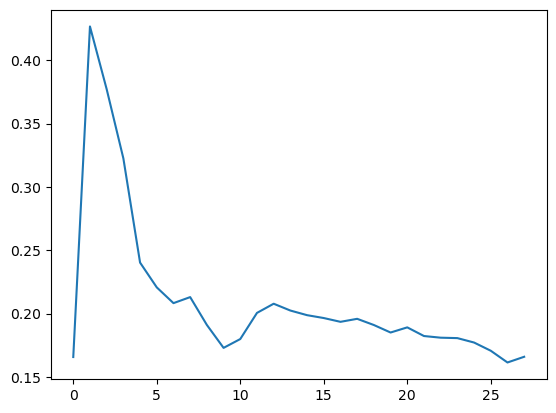

In [92]:
plt.plot(Cold_Gas_Ratio_Matrix[0,:])


In [97]:
merger_tree


{'count': 100,
 'SubfindID': array([117251, 118173, 118993, 118073, 118834, 119489, 119267, 119536,
        119443, 306385, 314723, 310101, 307992, 303997, 301575, 295401,
        289189, 286995, 288426, 286604, 284115, 280708, 279246, 283531,
        276290, 269249, 264457, 260912, 258112, 249655, 245964, 237312,
        232227, 229906, 224800, 220533, 212511, 211409, 207448, 197810,
        196722, 189900, 187942, 185260, 183681, 175230, 173397, 167341,
        162184, 160370, 184429, 183024, 179564, 170645, 161039, 155393,
        151939, 151802, 140651, 127069, 136414, 128195, 122310, 112155,
        101395,  94446,  91433,  82594,  77516,  74878,  68257,  58018,
         54375,  45818,  41823,  36429,  47718,  59769,  61429,  54823,
         50265,  43058,  32590,  29672,  31015,  40164,  44343,  35327,
         26342,  23393,  19762,  26586,  12864,  17796,  14321,  12942,
         11837,  12375,   6398,   4260], dtype=int32),
 'SnapNum': array([99, 98, 97, 96, 95, 94, 93, 92, 91

In [100]:
gm=list()
for current_snapshot,subfind_index in FunctionLib.Binary_DataIter(merger_tree['SnapNum'],merger_tree['SubfindID']):
    if current_snapshot < Snapshot_Init: break
    gm.append(il.groupcat.loadSingle(basePath,current_snapshot,-1,subfind_index)['SubhaloMassType'][0])


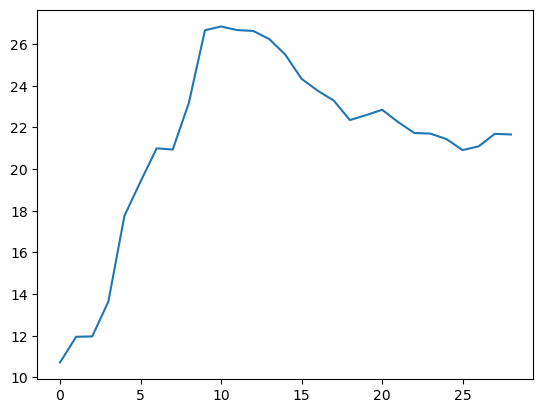

In [101]:
plt.plot(gm)


In [102]:
il.groupcat.loadSingle(basePath,99,-1,117251)['SubhaloMassType'][0]


10.715141